In [1]:
import numpy as np
import scipy
from tqdm import tqdm_notebook as tqdm

import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest
from scipy.stats import kstest, mannwhitneyu, ttest_ind, uniform

import matplotlib.pyplot as plt
import seaborn as sns

import hashlib
from base64 import b64encode
import collections


import warnings
warnings.filterwarnings('ignore')

/Users/alsukurmakaeva/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
alpha = 0.05
n_iter = 1000 

# Fuctions

In [3]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')

def groups_splitter(df, columns, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

In [4]:
def calc_iteration(df, test_type='ttest', effect=0.0, value_column='cart_added_cnt', log_transformed = False,):
    new_df = groups_splitter(df.copy(), columns=['user_id', 'group', value_column])

    group_a = new_df[new_df['group'] == 'A'][value_column].values
    group_b = new_df[new_df['group'] == 'B'][value_column].values

    if log_transformed and effect != 0:
        group_b += np.log1p(effect)
    else:
        group_b = group_b * (1. + effect)

    if test_type == 'ttest':
        return ttest_ind(group_a, group_b).pvalue

    elif test_type == 'mannwhitneyu':
        return mannwhitneyu(group_a, group_b).pvalue


In [5]:
def calc_correctness(df, test_type='ttest', value_column='cart_added_cnt',n_iters=n_iter):
    results = []

    for i in tqdm(range(n_iters), desc='Оценка корректности'):
        result = calc_iteration(df, test_type, 0.0, value_column, False)  
        results.append(result < alpha)

    test_correctness = collections.Counter(results)

    return (1 - test_correctness[1] / (test_correctness[1] + test_correctness[0])) * 100



def calc_power(df, test_type='ttest', effect=0.005, value_column='cart_added_cnt', n_iters=n_iter, log_transformed=False):
    results = []

    for i in tqdm(range(n_iters), desc='Оценка мощности'):
        result = calc_iteration(df, test_type, effect, value_column, log_transformed) 
        results.append(result < alpha)

    results = collections.Counter(results)

    return results[1] / (results[1] + results[0]) * 100



In [6]:
def run_statistical_tests(df, test_type, effect=0.005, value_column='cart_added_cnt', n_iters=n_iter, log_transformed=False):
    correctness = calc_correctness(df, test_type, value_column, n_iters)
    print(f'Корректность теста: {correctness:.2f}%')

    power = calc_power(df, test_type, effect, value_column, n_iters, log_transformed)
    print(f'Мощность теста для {100 * effect:.1f}% эффекта: {power:.2f}%')

    p_values = []
    for i in tqdm(range(n_iters), desc='Оценка распределения p-value'):
        p_value = calc_iteration(df, test_type, 0.0, value_column)
        p_values.append(p_value)
    
    _, p_value = kstest(p_values, uniform(loc=0.0, scale=1.0).cdf)

    if p_value < 0.05:
        print(f'p_value = {p_value:.2f} - неравномерное распределение p-value у теста {test_type}')
    else:
        print(f'p_value = {p_value:.2f} - равномерное распределение p-value у теста {test_type}')

    sns.histplot(p_values, bins=10, color='purple', kde=True)



# Подготовка данных

In [7]:
shop_metrics_new = pd.read_csv('shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('shop_df_users.csv').drop(columns='Unnamed: 0')

Метрики:
   - is_viewed - айтем товара просмотрен
   - products_viewed_cnt - количество уникальных просмотренных айтемов
   - price_sum - суммарная цена товаров
   - is_cart_added - товар добавлен в корзину
   - is_purchased - товар куплен
   - cart_added_cnt - количество товаров, добавленных в корзину
   - purchased_cnt - количество купленных товаров

<Axes: xlabel='cart_added_cnt', ylabel='Count'>

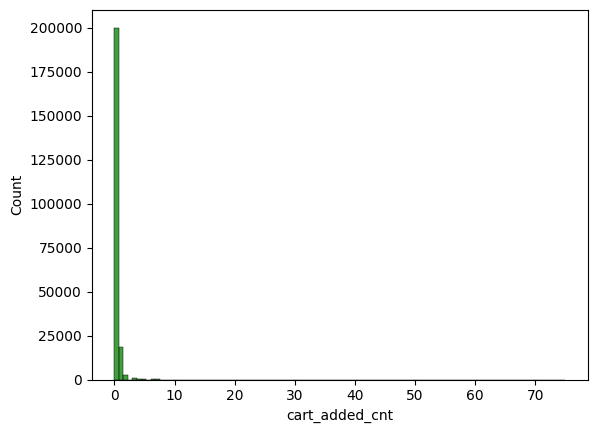

In [8]:
sns.histplot(data=shop_metrics_new, x='cart_added_cnt', bins=100, color='green')

**Выводы**

- Исходя из графика распределения значений метрики cart_added_cnt мы видим, что есть сильный перекос в сторону нулевых значений

In [9]:
shop_metrics_new.groupby('group')['cart_added_cnt'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,111321.0,0.135042,0.616917,0.0,0.0,0.0,0.0,61.0
B,111200.0,0.138552,0.651705,0.0,0.0,0.0,0.0,75.0


In [10]:
np.percentile(shop_metrics_new['cart_added_cnt'], 99.9)

6.0

In [11]:
shop_metrics_new[shop_metrics_new['cart_added_cnt'] > 0]['user_id'].count()

22445

## 1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt (5 баллов)

t-тест метрике cart_added_cnt


Оценка корректности:   0%|          | 0/1000 [00:00<?, ?it/s]

Корректность теста: 95.30%


Оценка мощности:   0%|          | 0/1000 [00:00<?, ?it/s]

Мощность теста для 0.5% эффекта: 4.70%


Оценка распределения p-value:   0%|          | 0/1000 [00:00<?, ?it/s]

p_value = 0.11 - равномерное распределение p-value у теста ttest


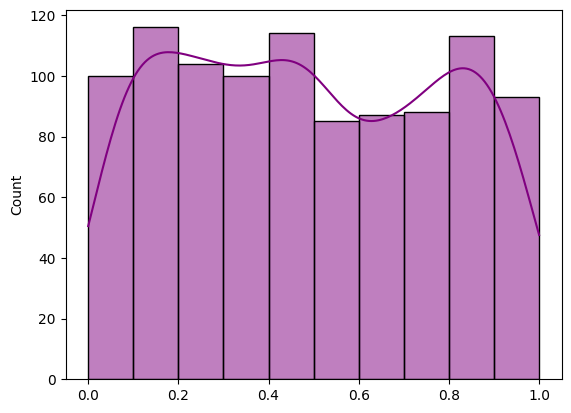

In [12]:
print('t-тест метрике cart_added_cnt')
run_statistical_tests(shop_metrics_new, test_type='ttest', value_column='cart_added_cnt')



Тест Манна-Уитни на обычной метрике cart_added_cnt:


Оценка корректности:   0%|          | 0/1000 [00:00<?, ?it/s]

Корректность теста: 94.90%


Оценка мощности:   0%|          | 0/1000 [00:00<?, ?it/s]

Мощность теста для 0.5% эффекта: 100.00%


Оценка распределения p-value:   0%|          | 0/1000 [00:00<?, ?it/s]

p_value = 0.33 - равномерное распределение p-value у теста mannwhitneyu


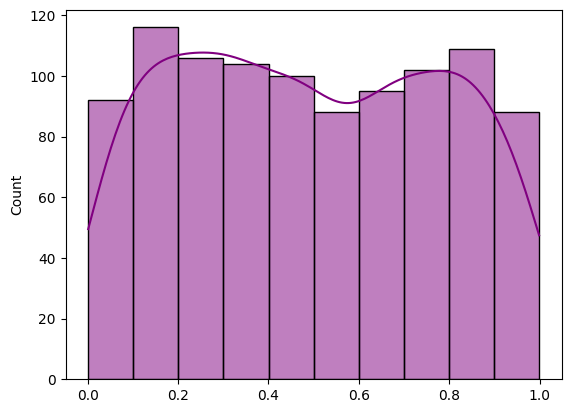

In [13]:
print('Тест Манна-Уитни на обычной метрике cart_added_cnt:')
run_statistical_tests(shop_metrics_new, test_type='mannwhitneyu', value_column='cart_added_cnt')



In [14]:
def rank_transformation(df, metric):
    df = df.copy()
    df['rank'] = df[metric].rank()
    return df


In [15]:
ranked = rank_transformation(shop_metrics_new, metric='cart_added_cnt')
ranked

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,100038.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,100038.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,100038.5
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,100038.5
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,100038.5
...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,100038.5
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,100038.5
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,100038.5
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,100038.5


In [16]:
ranked[ranked['cart_added_cnt'] > 0].shape

(22445, 10)

In [17]:
print('Средний ранг в группе A', ranked[ranked.group == 'A']['rank'].mean())
print('Средний ранг в группе B', ranked[ranked.group == 'B']['rank'].mean())
print('% изменения средних рангов в группе B и A:',
    (ranked[ranked.group == 'B']['rank'].mean() - ranked[ranked.group == 'A']['rank'].mean())
    / ranked[ranked.group == 'A']['rank'].mean()* 100)



Средний ранг в группе A 111170.45633348604
Средний ранг в группе B 111351.6421897482
% изменения средних рангов в группе B и A: 0.16298022175842064


In [18]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])

TtestResult(statistic=-1.2743727811526857, pvalue=0.20253266477504916, df=222519.0)

t-тест на ранге метрики cart_added_cnt


Оценка корректности:   0%|          | 0/1000 [00:00<?, ?it/s]

Корректность теста: 95.30%


Оценка мощности:   0%|          | 0/1000 [00:00<?, ?it/s]

Мощность теста для 0.5% эффекта: 97.20%


Оценка распределения p-value:   0%|          | 0/1000 [00:00<?, ?it/s]

p_value = 0.36 - равномерное распределение p-value у теста ttest


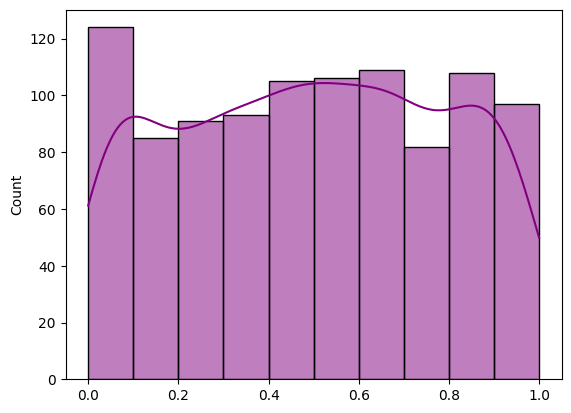

In [19]:
print('t-тест на ранге метрики cart_added_cnt')
run_statistical_tests(ranked, test_type='ttest', value_column='rank')



Тест Манна-Уитни на ранге метрики cart_added_cnt


Оценка корректности:   0%|          | 0/1000 [00:00<?, ?it/s]

Корректность теста: 94.20%


Оценка мощности:   0%|          | 0/1000 [00:00<?, ?it/s]

Мощность теста для 0.5% эффекта: 100.00%


Оценка распределения p-value:   0%|          | 0/1000 [00:00<?, ?it/s]

p_value = 0.30 - равномерное распределение p-value у теста mannwhitneyu


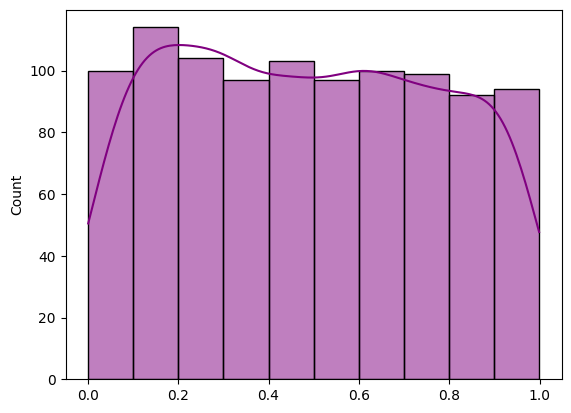

In [20]:
print('Тест Манна-Уитни на ранге метрики cart_added_cnt')
run_statistical_tests(ranked, test_type='mannwhitneyu', value_column='rank')

### Вывод

- исходя из значений мощности на t-test для исходной метрики = 4.70% и для метрики после рангового преобразования = 97.20%, видно, что ранговое преобразование сильно повлияло на этот тест
- для критерия Манна-Уитни ранговое преобразование не сильно повлияло на мощность (= 100.00% в обоих случаях)

# 2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt (5 баллов)
- логарфимированной метрике cart_added_cnt (5 баллов)
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)

## обычная метрика cart_added_cnt

In [21]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()

In [22]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all.rename(columns={
        'cart_added_cnt_x': 'cart_added_cnt',
        'cart_added_cnt_y': 'cart_added_cnt_covariate'})



In [23]:
shop_metrics_all.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0


In [24]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

In [25]:
shop_metrics_all_cuped.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.132761
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.132761
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.132761
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,0.132761
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,0.132761


Проверим, как на измененной метрике покажет себя t-test:

t-тест на cuped-метрике cart_added_cnt


Оценка корректности:   0%|          | 0/1000 [00:00<?, ?it/s]

Корректность теста: 93.90%


Оценка мощности:   0%|          | 0/1000 [00:00<?, ?it/s]

Мощность теста для 0.5% эффекта: 22.60%


Оценка распределения p-value:   0%|          | 0/1000 [00:00<?, ?it/s]

p_value = 0.03 - неравномерное распределение p-value у теста ttest


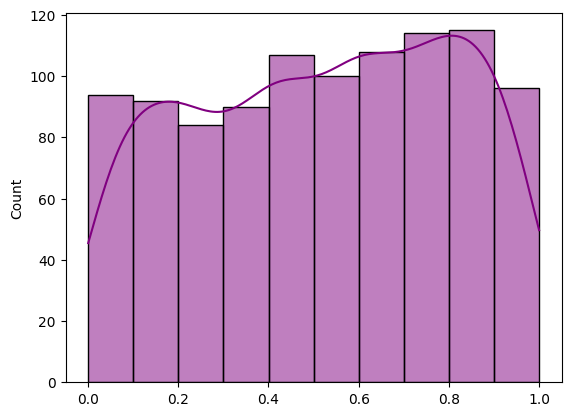

In [26]:
print('t-тест на cuped-метрике cart_added_cnt')
run_statistical_tests(shop_metrics_all_cuped, test_type='ttest', value_column='cart_added_cnt_cuped')



Сравним средние в измененной метрике и дисперсии:

In [27]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}')

метрика_cuped A: 0.13638231572657297,         метрика_cuped B: 0.13721028984714181
метрика без cuped A: 0.1350419058398685,         метрика без cuped B: 0.1385521582733813


In [28]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].var()}')

метрика_cuped A: 0.01823518359964533,         метрика_cuped B: 0.021495363455396536
метрика без cuped A: 0.3805867322090304,         метрика без cuped B: 0.4247189893567569


**Выводы**
- p-value для cuped преобразованной метрики снизился
- однако все хорошо: средние сохранились, а дисперсии изменились => понимаем, почему снизился p-value
- значение мощности выросло с 4.70% до 22.60%

## логарифмированная метрика cart_added_cnt

In [29]:
shop_metrics_all['cart_added_cnt_log'] = np.log(shop_metrics_all['cart_added_cnt'] + 1)
shop_metrics_all['cart_added_cnt_log_covariate'] = np.log(shop_metrics_all['cart_added_cnt_covariate'] + 1)

shop_metrics_all_cuped_ln = cuped_transform(shop_metrics_all, ['cart_added_cnt_log'])

In [30]:
shop_metrics_all_cuped_ln.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_log,cart_added_cnt_log_covariate,cart_added_cnt_log_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.0,0.0,0.080004
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.0,0.0,0.080004
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.0,0.0,0.080004
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,0.0,0.0,0.080004
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,0.0,0.0,0.080004


t-тест на cuped-метрике cart_added_cnt_log


Оценка корректности:   0%|          | 0/1000 [00:00<?, ?it/s]

Корректность теста: 93.50%


Оценка мощности:   0%|          | 0/1000 [00:00<?, ?it/s]

Мощность теста для 0.5% эффекта: 58.70%


Оценка распределения p-value:   0%|          | 0/1000 [00:00<?, ?it/s]

p_value = 0.44 - равномерное распределение p-value у теста ttest


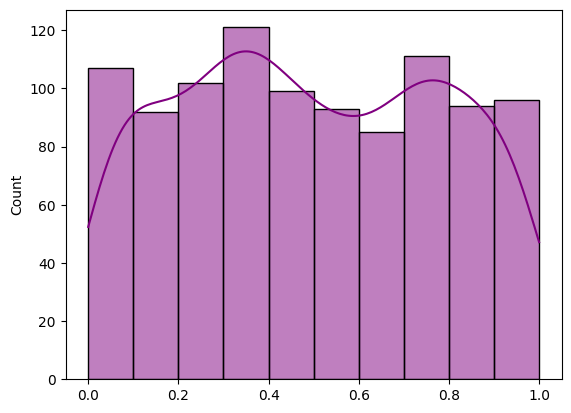

In [31]:
print('t-тест на cuped-метрике cart_added_cnt_log')
run_statistical_tests(shop_metrics_all_cuped_ln, test_type='ttest', value_column='cart_added_cnt_log_cuped')


Сравним средние в измененной метрике и дисперсии:

In [32]:
print(f'метрика_cuped A: {shop_metrics_all_cuped_ln[shop_metrics_all_cuped_ln.group == "A"]["cart_added_cnt_log_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped_ln[shop_metrics_all_cuped_ln.group == "B"]["cart_added_cnt_log_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped_ln[shop_metrics_all_cuped_ln.group == "A"]["cart_added_cnt_log"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped_ln[shop_metrics_all_cuped_ln.group == "B"]["cart_added_cnt_log"].mean()}')

метрика_cuped A: 0.08034157852348374,         метрика_cuped B: 0.08072086382541542
метрика без cuped A: 0.07974289062640032,         метрика без cuped B: 0.08132020317245879


In [33]:
print(f'метрика_cuped A: {shop_metrics_all_cuped_ln[shop_metrics_all_cuped_ln.group == "A"]["cart_added_cnt_log_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped_ln[shop_metrics_all_cuped_ln.group == "B"]["cart_added_cnt_log_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped_ln[shop_metrics_all_cuped_ln.group == "A"]["cart_added_cnt_log"].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped_ln[shop_metrics_all_cuped_ln.group == "B"]["cart_added_cnt_log"].var()}')

метрика_cuped A: 0.002055014378642917,         метрика_cuped B: 0.0017558187333519078
метрика без cuped A: 0.06466232955752058,         метрика без cuped B: 0.06628259108478471


**Выводы**
- аналогично p-value для cuped преобразованной метрики = 0.44
- при этом также средние сохранились, а дисперсии изменились => понимаем, почему снизился p-value
- значение мощности = 58.70%

## метрика cart_added_cnt после рангового преобразования

In [34]:
shop_metrics_all = rank_transformation(shop_metrics_all, 'cart_added_cnt')

In [35]:
shop_metrics_all.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_log,cart_added_cnt_log_covariate,cart_added_cnt_log_cuped,rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.0,0.0,0.080004,100038.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.0,0.0,0.080004,100038.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.0,0.0,0.080004,100038.5
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,0.0,0.0,0.080004,100038.5
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,0.0,0.0,0.080004,100038.5


In [36]:
shop_metrics_all['rank_covariate'] = shop_metrics_all[shop_metrics_all['group'] == 'B']['rank']

In [37]:
shop_metrics_all.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_log,cart_added_cnt_log_covariate,cart_added_cnt_log_cuped,rank,rank_covariate
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.0,0.0,0.080004,100038.5,NaN
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.0,0.0,0.080004,100038.5,NaN
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.0,0.0,0.080004,100038.5,NaN
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,0.0,0.0,0.080004,100038.5,100038.5
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,0.0,0.0,0.080004,100038.5,100038.5


In [38]:
shop_metrics_all_rank_cuped = cuped_transform(shop_metrics_all, ['rank'])

t-тест на cuped-метрике rank_cuped


Оценка корректности:   0%|          | 0/1000 [00:00<?, ?it/s]

Корректность теста: 96.10%


Оценка мощности:   0%|          | 0/1000 [00:00<?, ?it/s]

Мощность теста для 0.5% эффекта: 98.90%


Оценка распределения p-value:   0%|          | 0/1000 [00:00<?, ?it/s]

p_value = 0.28 - равномерное распределение p-value у теста ttest


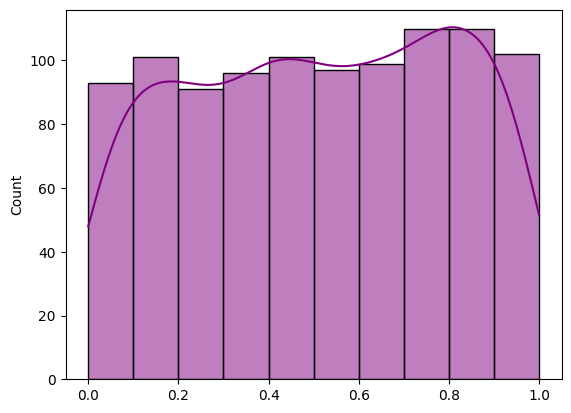

In [39]:
print('t-тест на cuped-метрике rank_cuped')
run_statistical_tests(shop_metrics_all_rank_cuped, test_type='ttest', value_column='rank_cuped')

In [40]:
print(f'метрика_cuped A: {shop_metrics_all_rank_cuped[shop_metrics_all_rank_cuped.group == "A"]["rank_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_rank_cuped[shop_metrics_all_rank_cuped.group == "B"]["rank_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_rank_cuped[shop_metrics_all_rank_cuped.group == "A"]["rank"].mean()}, \
        метрика без cuped B: {shop_metrics_all_rank_cuped[shop_metrics_all_rank_cuped.group == "B"]["rank"].mean()}')

метрика_cuped A: 119840.69886251065,         метрика_cuped B: 102671.9653140868
метрика без cuped A: 111170.45633348604,         метрика без cuped B: 111351.6421897482


In [41]:
print(f'метрика_cuped A: {shop_metrics_all_rank_cuped[shop_metrics_all_rank_cuped.group == "A"]["rank_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_rank_cuped[shop_metrics_all_rank_cuped.group == "B"]["rank_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_rank_cuped[shop_metrics_all_rank_cuped.group == "A"]["rank"].var()}, \
        метрика без cuped B: {shop_metrics_all_rank_cuped[shop_metrics_all_rank_cuped.group == "B"]["rank"].var()}')

метрика_cuped A: 1116108735.2907896,         метрика_cuped B: 807391318.2497903
метрика без cuped A: 1116108735.2907896,         метрика без cuped B: 1132936846.743577


**Выводы**
- аналогично p-value для cuped преобразованной метрики немного снизился
- при этом средние изменились, а дисперсии сильно выросли 
- значение мощности выросло с 97.20% до 98.90%

### Вывод

- cuped преобразование снижает p-value и повышает мощность


# 3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные) (5 баллов)
- на метрике cart_added_cnt (5 баллов)

## на логнормальном распределении (сгенерированные данные) 

In [42]:
log_norm_data = np.random.lognormal(mean=2., sigma=1., size=1000)
df_lognorm = pd.DataFrame({'user_id': range(1000), 'metric': log_norm_data})

In [43]:
df_lognorm.head()

,user_id,metric
0,0,140.292426
1,1,41.448917
2,2,1.401390
3,3,6.625859
4,4,3.457010


<Axes: xlabel='metric', ylabel='Count'>

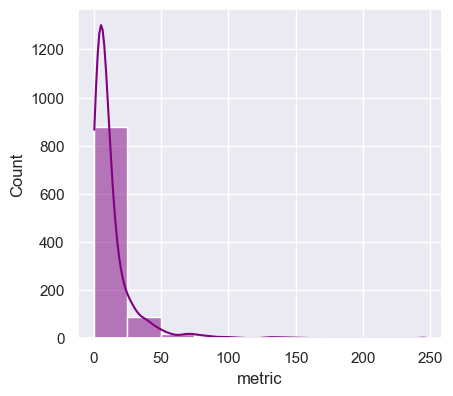

In [44]:
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=df_lognorm['metric'], bins=10, color='purple', kde=True)

t-тест без бакетирования на логнормальной выборке


Оценка корректности:   0%|          | 0/1000 [00:00<?, ?it/s]

Корректность теста: 94.70%


Оценка мощности:   0%|          | 0/1000 [00:00<?, ?it/s]

Мощность теста для 0.5% эффекта: 6.30%


Оценка распределения p-value:   0%|          | 0/1000 [00:00<?, ?it/s]

p_value = 0.64 - равномерное распределение p-value у теста ttest


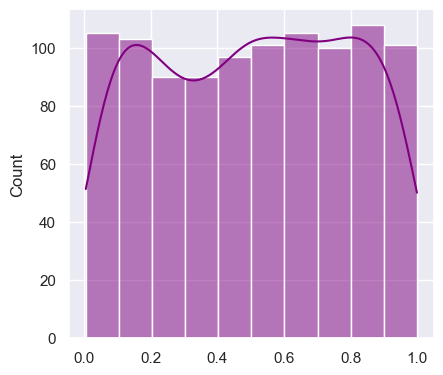

In [45]:
print('t-тест без бакетирования на логнормальной выборке')
run_statistical_tests(df_lognorm, test_type='ttest', value_column='metric')

In [46]:
def groups_splitter_buckets(df, columns, n_buckets):
    chunks = np.array_split(df, n_buckets)
    
    chunks[0]['backet'] = 0
    res_df = groups_splitter(chunks[0], columns)
    
    for n in range(1, len(chunks)):
        chunks[n]['backet'] = n
        part_df = groups_splitter(chunks[n], columns)
        res_df= res_df._append(part_df)
        
    return res_df

In [47]:
df_lognorm_backet = groups_splitter_buckets(df_lognorm, ['user_id', 'metric', 'backet', 'group'], 100)

In [48]:
df_lognorm_backet.groupby('group')[['user_id']].count()

,user_id
group,
A,494
B,506


In [49]:
df_lognorm_backet.groupby(['group', 'backet'])[['user_id']].count()

user_id
group backet         
A     0             3
      1             6
      2             7
      3             5
      4             3
...               ...
B     95            3
      96            6
      97            7
      98            5
      99            6

[200 rows x 1 columns]

t-тест с бакетированием на логнормальной выборке


Оценка корректности:   0%|          | 0/1000 [00:00<?, ?it/s]

Корректность теста: 94.90%


Оценка мощности:   0%|          | 0/1000 [00:00<?, ?it/s]

Мощность теста для 0.5% эффекта: 3.90%


Оценка распределения p-value:   0%|          | 0/1000 [00:00<?, ?it/s]

p_value = 0.29 - равномерное распределение p-value у теста ttest


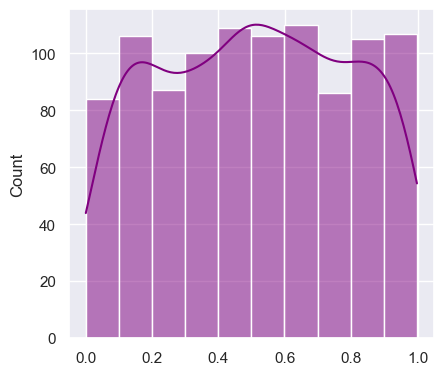

In [50]:
print('t-тест с бакетированием на логнормальной выборке')
run_statistical_tests(df_lognorm_backet, test_type='ttest', value_column='metric')

## на метрике cart_added_cnt

In [51]:
shop_metrics_new_backet = groups_splitter_buckets(shop_metrics_new, columns=['user_id', 'cart_added_cnt', 'backet', 'group'], n_buckets=100)

In [52]:
shop_metrics_new_backet.head()

,user_id,cart_added_cnt,backet,group
0,1515915625353230683,0,0,B
1,1515915625353234047,0,0,A
2,1515915625353236157,0,0,A
3,1515915625353294441,0,0,A
4,1515915625353386199,0,0,B


In [53]:
shop_metrics_new_backet.groupby('group')[['user_id']].count()

,user_id
group,
A,111352
B,111169


t-тест с бакетированием на метрике cart_added_cnt


Оценка корректности:   0%|          | 0/1000 [00:00<?, ?it/s]

Корректность теста: 93.30%


Оценка мощности:   0%|          | 0/1000 [00:00<?, ?it/s]

Мощность теста для 0.5% эффекта: 6.30%


Оценка распределения p-value:   0%|          | 0/1000 [00:00<?, ?it/s]

p_value = 0.30 - равномерное распределение p-value у теста ttest


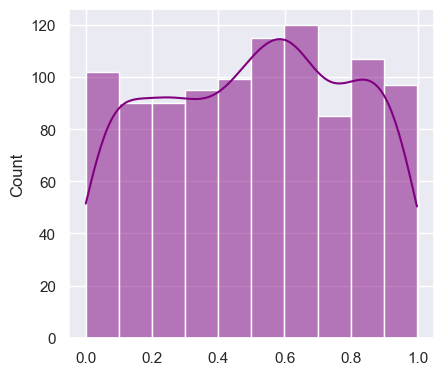

In [54]:
print('t-тест с бакетированием на метрике cart_added_cnt')
run_statistical_tests(shop_metrics_new_backet, test_type='ttest', value_column='cart_added_cnt')

t-тест метрике cart_added_cnt
- Корректность теста: 95.30%
- Мощность теста для 0.5% эффекта: 4.70%
- p_value = 0.11 - равномерное распределение p-value у теста ttest


t-тест с бакетированием на метрике cart_added_cnt
- Корректность теста: 93.30%
- Мощность теста для 0.5% эффекта: 6.30%
- p_value = 0.30 - равномерное распределение p-value у теста ttest

t-тест без бакетирования на логнормальной выборке
- Корректность теста: 94.70%
- Мощность теста для 0.5% эффекта: 6.30%
- p_value = 0.64 - равномерное распределение p-value у теста ttest

t-тест с бакетированием на логнормальной выборке
- Корректность теста: 94.90%
- Мощность теста для 0.5% эффекта: 3.90%
- p_value = 0.29 - равномерное распределение p-value у теста ttest

### Вывод

- бакетирование неоднозначно повлияло на p_value, при этом мощности не сильно изменились



# 4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)
подсчитать результаты для случая без постстратификации и с постстратификацией
- проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)

In [55]:
shop_users_info.head()

,user_id,user_age,user_sex
0,1515915625519388267,41,f
1,1515915625519380411,84,m
2,1515915625513238515,41,m
3,1515915625519014356,25,m
4,1515915625510743344,42,m


In [56]:
shop_metrics_new = shop_metrics_new.merge(shop_users_info, how='left')
shop_metrics_old = shop_metrics_old.merge(shop_users_info, how='left')

In [57]:
age_bins = [17, 24, 45, 60, 75, np.inf]
age_labels = ['18_24', '25_45', '46_60', '61_75', '76+']

shop_metrics_old['age_group'] = pd.cut(shop_metrics_old['user_age'], bins=age_bins, labels=age_labels)

In [58]:
shop_metrics_old.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,user_age,user_sex,age_group
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0,55,f,46_60
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0,58,m,46_60
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0,23,f,18_24
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0,33,m,25_45
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0,26,f,25_45


In [59]:
shop_metrics_old['strats'] = (shop_metrics_old['user_sex'].astype(str) + '_' + shop_metrics_old['age_group'].astype(str))

shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'strats']], on='user_id', how='left')

In [60]:
shop_metrics_all.groupby('group')[['user_id']].count()

,user_id
group,
A,111321
B,111200


In [61]:
n = 0
columns = ['user_id', 'cart_added_cnt', 'strats', 'group']

for strat in shop_metrics_all.strats.unique():
    if n == 0:
        prom_df = shop_metrics_all[shop_metrics_all.strats == strat]
        prom_df.reset_index(drop=True, inplace=True)
        res_df = groups_splitter(prom_df, columns)
    else:
        prom_df = shop_metrics_all[shop_metrics_all.strats == strat]
        prom_df.reset_index(drop=True, inplace=True)
        prom_df = groups_splitter(prom_df, columns)
        res_df = res_df._append(prom_df)
    n += 1
    
res_df.groupby('group')[['user_id']].count()

,user_id
group,
A,111260
B,111261


In [62]:
res_df.head()

,user_id,cart_added_cnt,strats,group
0,1515915625353230683,0,f_18_24,A
1,1515915625355805313,1,f_18_24,B
2,1515915625358008624,0,f_18_24,A
3,1515915625367976920,1,f_18_24,A
4,1515915625369372234,0,f_18_24,A


t-тест с постстратификацией на метрике cart_added_cnt


Оценка корректности:   0%|          | 0/1000 [00:00<?, ?it/s]

Корректность теста: 94.90%


Оценка мощности:   0%|          | 0/1000 [00:00<?, ?it/s]

Мощность теста для 0.5% эффекта: 4.70%


Оценка распределения p-value:   0%|          | 0/1000 [00:00<?, ?it/s]

p_value = 0.43 - равномерное распределение p-value у теста ttest


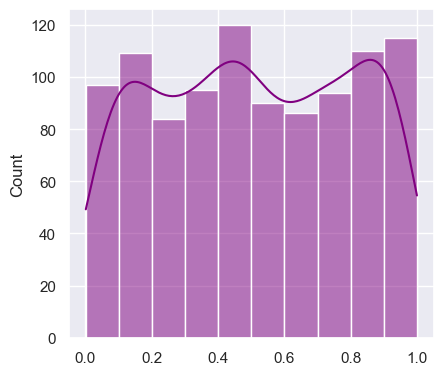

In [63]:
print('t-тест с постстратификацией на метрике cart_added_cnt')
run_statistical_tests(res_df, test_type='ttest', value_column='cart_added_cnt')


In [67]:
res_df.head()

,user_id,cart_added_cnt,strats,group
0,1515915625353230683,0,f_18_24,A
1,1515915625355805313,1,f_18_24,B
2,1515915625358008624,0,f_18_24,A
3,1515915625367976920,1,f_18_24,A
4,1515915625369372234,0,f_18_24,A


### Вывод

- стратификация также не повлияла на мощности

